In [1]:
library(data.table)
library(stringr)
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
calls_df <- read.table("/stanley/stemcell/concordance/ground_truth/SCBB_CIRM_McLean_Levy_WGS/v2/mocha/SCBB_CIRM_ML_WGS.calls.tsv",sep="\t",header=T)
head(calls_df)

,sample_id,computed_gender,chrom,beg_GRCh38,end_GRCh38,length,p_arm,q_arm,n_sites,n_hets,...,bdev_se,rel_cov,rel_cov_se,lod_lrr_baf,lod_baf_phase,n_flips,baf_conc,lod_baf_conc,type,cf
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>
1,CW60054,M,chr1,34636186,34645953,9767,Y,N,21,0,...,NaN,1.0966,0.0645,13.80,NaN,-1,NaN,0.0,CNP_Loss,NaN
2,CW60054,M,chr1,110834341,110845334,10993,Y,N,25,0,...,NaN,1.0580,0.0637,17.49,NaN,-1,NaN,0.0,CNP_Loss,NaN
3,CW60054,M,chr1,152788067,152798400,10333,N,Y,24,0,...,NaN,1.1658,0.0638,14.08,NaN,-1,NaN,0.0,CNP_Loss,NaN
4,CW60054,M,chr1,212829029,212840271,11242,N,Y,25,1,...,NaN,1.1634,0.0443,13.13,NaN,-1,NaN,0.0,CNP_Loss,NaN
5,CW60054,M,chr1,241569718,241580526,10808,N,Y,23,0,...,NaN,1.1552,0.0476,12.82,NaN,-1,NaN,0.0,CNP_Loss,NaN
6,CW60054,M,chr1,13226385,13370316,143931,Y,N,40,8,...,NaN,3.1322,0.1738,21.35,10.55,-1,1,2.1,Gain,1


In [10]:
flag_calls <- function(calls,omit_15q=TRUE) {
    flagged_calls <- calls[calls$length>5e5 & calls$cf==1 & calls$rel_cov>2.5 & !is.na(calls$lod_baf_phase)  & calls$lod_baf_phase<10 & !is.na(calls$cf),]
    if (omit_15q) {
        flagged_calls <- flagged_calls[!(flagged_calls$chrom=="chr15" & flagged_calls$q_arm=="Y"),]
    }
    flagged_calls$cohort <- ifelse(startsWith(flagged_calls$sample_id,"CW"),"CIRM","McLean-Levy")
    return(flagged_calls)
}
summarize_types <- function(calls,.omit_15q=TRUE) {
    # filter calls to only major CNV events that are not mosaic
    flagged_calls <- flag_calls(calls,omit_15q=.omit_15q)

    window_breaks<-c(5e5,1e6,5e6,50e6)

    summary_df <- data.frame(window_min_mb=window_breaks/1e6)
    summary_df$count <- numeric(length(window_breaks))
    summary_df$gain <- numeric(length(window_breaks))
    summary_df$loss <- numeric(length(window_breaks))
    summary_df$unique_donors <- numeric(length(window_breaks))
    summary_df$cirm <- numeric(length(window_breaks))
    summary_df$ml <- numeric(length(window_breaks))

    for (i in seq_along(window_breaks)) {
        if(is.na(window_breaks[i+1])) {
            # if we are at the maximum window (e.g., > 50Mb)
            summary_df[i,"count"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i],])
            summary_df[i,"gain"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$type=="Gain",])
            summary_df[i,"loss"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$type=="Loss",])
            summary_df[i,"unique_donors"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i],"sample_id"]))
            summary_df[i,"cirm"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$cohort=="CIRM","sample_id"]))
            summary_df[i,"ml"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$cohort=="McLean-Levy","sample_id"]))
        } else {
            # if we are not at the maximum window (<50Mb)
            summary_df[i,"count"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1],])
            summary_df[i,"gain"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1] & flagged_calls$type=="Gain",])
            summary_df[i,"loss"] <- nrow(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1] & flagged_calls$type=="Loss",])
            summary_df[i,"unique_donors"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1],"sample_id"]))
            summary_df[i,"cirm"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1] & flagged_calls$cohort=="CIRM","sample_id"]))
            summary_df[i,"ml"] <- length(unique(flagged_calls[flagged_calls$length>window_breaks[i] & flagged_calls$length<window_breaks[i+1] & flagged_calls$cohort=="McLean-Levy","sample_id"]))
        }
    }
    return(summary_df)
}
cnv_lengths_plot <- function(flagged_calls) {
    yval=-10
    p<- ggplot(flagged_calls,aes(x=log10(length))) +
            geom_histogram() +
            labs(y="count") +
            theme_minimal() +
            geom_vline(xintercept=log10(5e5),linetype="dashed",color="red") +
            annotate("text",x=log10(5e5), label="\n0.5Mb", y=yval, colour="red", angle=90) +
            geom_vline(xintercept=log10(1e6),linetype="dashed",color="red") +
            annotate("text",x=log10(1e6), label="\n1Mb", y=yval, colour="red", angle=90) +
            geom_vline(xintercept=log10(5e6),linetype="dashed",color="red") +
            annotate("text",x=log10(5e6), label="\n5Mb", y=yval, colour="red", angle=90) +
            geom_vline(xintercept=log10(50e6),linetype="dashed",color="red") +
            annotate("text",x=log10(50e6), label="\n50Mb", y=yval, colour="red", angle=90)
    return(p)
}
summary_df <- summarize_types(calls_df)
summary_df
colSums(summary_df)

window_min_mb,count,gain,loss,unique_donors,cirm,ml
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5,54,54,0,44,31,13
1.0,172,172,0,153,128,25
5.0,11,11,0,11,5,6
50.0,0,0,0,0,0,0


window_min_mb         count          gain          loss unique_donors 
         56.5         237.0         237.0           0.0         208.0 
         cirm            ml 
        164.0          44.0

In [21]:
length(unique(flagged_calls[flagged_calls$cohort=="CIRM","sample_id"]))
length(unique(flagged_calls[flagged_calls$cohort=="McLean-Levy","sample_id"]))
length(unique(flagged_calls$sample_id))

[1] 153

[1] 29

[1] 182

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


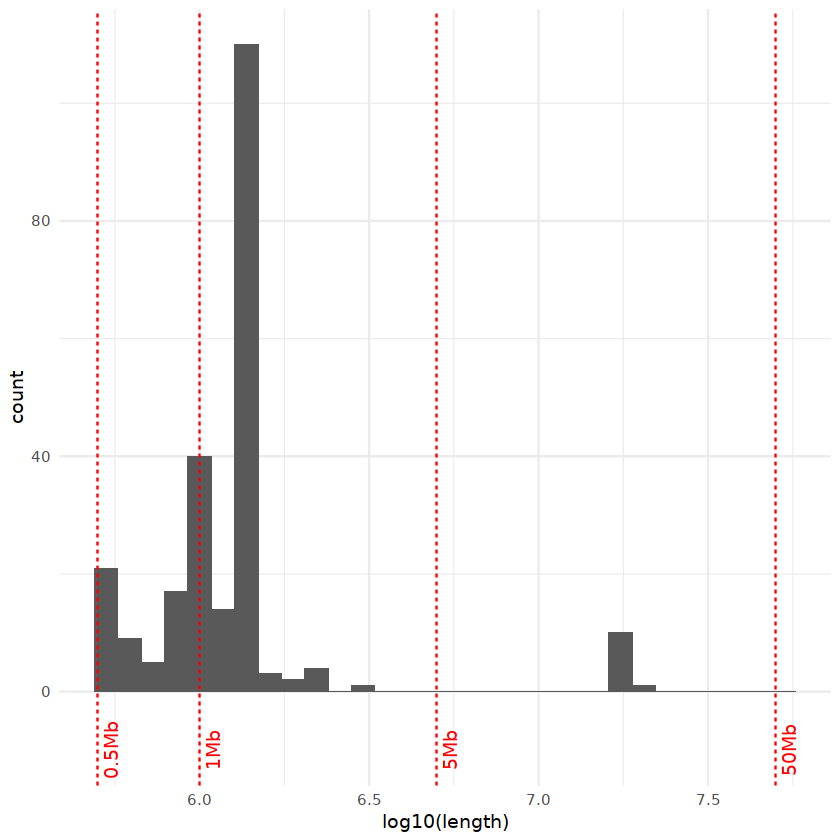

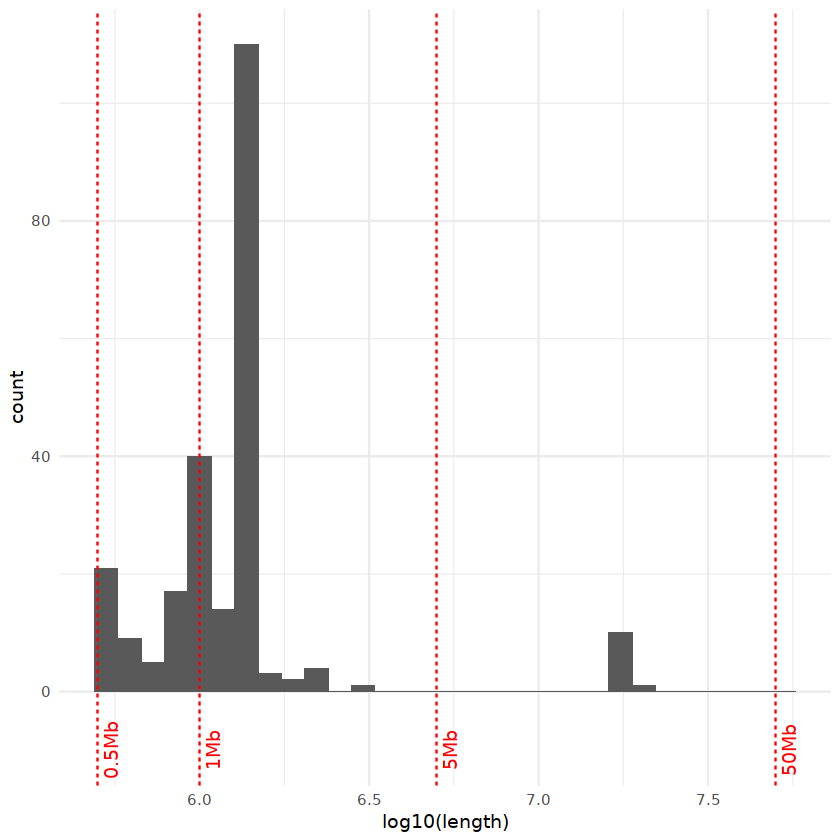

In [17]:
flagged_calls <- flag_calls(calls_df)
cnv_lengths_plot(flagged_calls)
no_15q <- flagged_calls[!(flagged_calls$chrom=="chr15" & flagged_calls$q_arm=="Y"),]
cnv_lengths_plot(no_15q)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


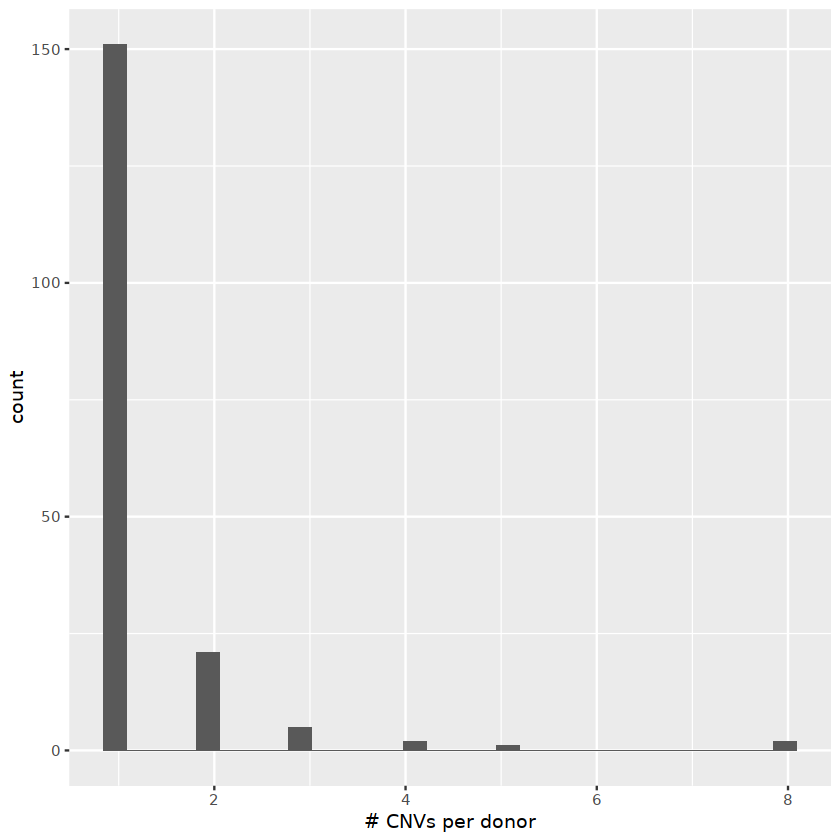

In [19]:
donor_cnvs <- data.frame(donor=unique(flagged_calls$sample_id))
donor_cnvs <- flagged_calls %>%
                    group_by(sample_id) %>%
                    summarize(n_cnvs=n())

ggplot(donor_cnvs,aes(x=n_cnvs)) +
    geom_histogram() +
    labs(x="# CNVs per donor")

In [26]:
# head(flagged_calls)
# subset(flagged_calls,select=-cohort)
write.table(subset(flagged_calls,select=-cohort),"/stanley/stemcell/concordance/ground_truth/SCBB_CIRM_McLean_Levy_WGS/v2/mocha/SCBB_CIRM_ML_WGS.flagged_calls.no15q.tsv",sep="\t",col.names=T,quote=F,row.names=F)
write.table(summary_df,"/stanley/stemcell/concordance/ground_truth/SCBB_CIRM_McLean_Levy_WGS/v2/mocha/SCBB_CIRM_ML_WGS.flagged_calls.no15q.summary.tsv",sep="\t",col.names=T,row.names=F,quote=F)